## AutoRegressive Model
* US population data
https://fred.stlouisfed.org/series/POPTHM

In [1]:
import numpy as np
import pandas as pd
from statsmodels.tsa.ar_model import ar_select_order, AutoReg

In [2]:
df = pd.read_csv('Data/uspopulation.csv', index_col='DATE', parse_dates=True)
df.index.freq = 'MS'
df.head()

,PopEst
DATE,
2011-01-01,311037
2011-02-01,311189
2011-03-01,311351
2011-04-01,311522
2011-05-01,311699


<Axes: xlabel='DATE'>

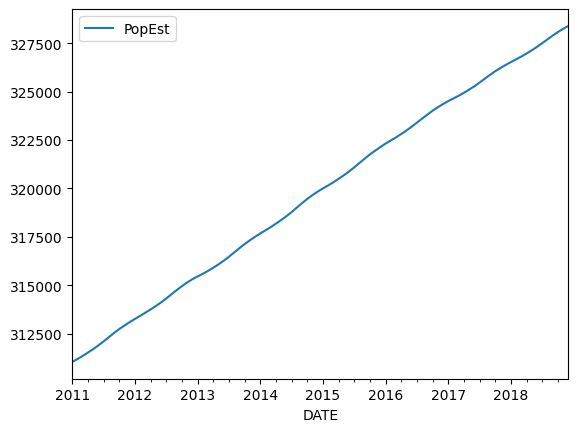

In [3]:
df.plot()
# from the plot we can see that it is quite linear although there is a bit of seasonality
# thus, the AR model should work well on this data

In [4]:
len(df)

96

In [5]:
train_data = df.iloc[:84]
test_data = df.iloc[84:]

### calculate the best number of lags to be used by AR model
* lags i.e. parameter p
* glob=True: This parameter specifies whether to use a global search for determining the best order. 
    * If glob is set to True, the function will perform an exhaustive search over all possible orders up to the maxlag parameter. 
    * If False, a stepwise search will be performed to find the best order. In this case, a global search is conducted.
    * Forward Selection: This method starts with an empty model and adds predictors one at a time based on a pre-defined criterion, such as the improvement in the model's fit (e.g., decrease in the residual sum of squares). It continues adding predictors until no further improvement is observed.
    * Backward Elimination: This method starts with a model containing all predictors and removes them one at a time based on a pre-defined criterion, such as the least significant improvement in the model's fit (e.g., smallest increase in the residual sum of squares). It continues removing predictors until no further improvement is observed.
* in our case the model with p=14 has better AIC compared to model with p=8 although p=8 has lower RMSE error in predicting test data

In [22]:
ar_order = ar_select_order(train_data['PopEst'], maxlag=8, ic='aic', glob=False).ar_lags
# ar_order_aic_glob = ar_select_order(train_data['PopEst'], maxlag=16, ic='aic', glob=True).ar_lags
ar_order_aic_glob = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 15]
# ar_order_bic_glob = ar_select_order(train_data['PopEst'], maxlag=16, ic='bic', glob=True).ar_lags
ar_order_bic_glob = [1, 2, 3, 12, 13, 14]
print(ar_order)
print(ar_order_bic_glob)
print(ar_order_aic_glob)

# ar_order = [1, 2, 3, 4, 5, 6, 7, 8]
# # Result with bic
# ar_order_bic_glob = [1, 2, 3, 12, 13, 14]
# glob=false [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

# # Result with hqic
# ar_order_hqic_glob = [1, 2, 3, 12, 13, 14]

# # Result with aic
# ar_order_aic_glob = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 15]

[1, 2, 3, 4, 5, 6, 7, 8]
[1, 2, 3, 12, 13, 14]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 15]


In [23]:
# model = ARIMA(train['PopEst'], freq='MS')
model_autoreg_1 = AutoReg(train_data['PopEst'], lags=[1]).fit()
model_autoreg_best = AutoReg(train_data['PopEst'], lags=ar_order).fit()
model_autoreg_aic_glob = AutoReg(train_data['PopEst'], lags=ar_order_aic_glob).fit()
model_autoreg_bic_glob = AutoReg(train_data['PopEst'], lags=ar_order_bic_glob).fit()

In [24]:
print(model_autoreg_aic_glob.aic)
print(model_autoreg_bic_glob.aic)
print(model_autoreg_best.aic)

413.87968049231785
419.77958605913403
488.3530527017233


In [25]:
model_autoreg_1.params

const        284.913797
PopEst.L1      0.999686
dtype: float64

In [26]:
model_autoreg_aic_glob.params

const         65.182512
PopEst.L1      2.362876
PopEst.L2     -2.160705
PopEst.L3      1.474878
PopEst.L4     -1.371794
PopEst.L5      1.314442
PopEst.L6     -1.311585
PopEst.L7      1.356768
PopEst.L8     -1.201810
PopEst.L9      1.168001
PopEst.L10    -1.394417
PopEst.L11     1.533103
PopEst.L12    -0.879184
PopEst.L15     0.109271
dtype: float64

In [27]:
model_autoreg_best.params

const        82.309677
PopEst.L1     2.437997
PopEst.L2    -2.302100
PopEst.L3     1.565427
PopEst.L4    -1.431211
PopEst.L5     1.125022
PopEst.L6    -0.919494
PopEst.L7     0.963694
PopEst.L8    -0.439511
dtype: float64

#### store the start and end of test data index


In [28]:
start = len(train_data)
end = len(train_data)+len(test_data)-1

In [29]:
predictions1 = model_autoreg_1.predict(start=start, end=end)
predictions1 = pd.DataFrame(data=predictions1, columns=['AR(1) Predictions'])

In [30]:
p = len(ar_order)
predictions_best = model_autoreg_best.predict(start=start, end=end)
predictions_best = pd.DataFrame(data=predictions_best, columns=[f'AR({p}) Predictions'])

In [40]:
p_aic = len(ar_order_aic_glob)
predictions_aic_glob = model_autoreg_aic_glob.predict(start=start, end=end)
predictions_aic_glob = pd.DataFrame(data=predictions_aic_glob, columns=[f'AR({p_aic}) Predictions AIC'])

In [41]:
p_bic = len(ar_order_bic_glob)
predictions_bic_glob = model_autoreg_bic_glob.predict(start=start, end=end)
predictions_bic_glob = pd.DataFrame(data=predictions_bic_glob, columns=[f'AR({p_bic}) Predictions BIC'])

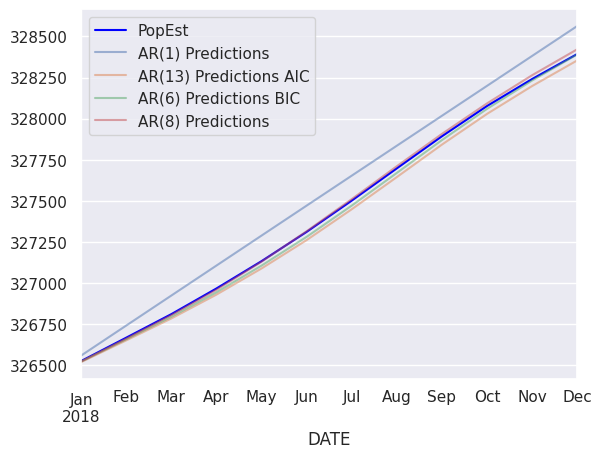

In [46]:
# test_data['PopEst'].plot(legend=True, label='TEST')
# predictions1['AR(1) Predictions'].plot(legend=True);
# predictions_best['AR(14) Predictions'].plot(legend=True);
ax = test_data.plot(legend=True, c='blue')
predictions1.plot(ax=ax, legend=True, alpha=0.5);
predictions_aic_glob.plot(ax=ax, legend=True, alpha=0.5);
predictions_bic_glob.plot(ax=ax, legend=True, alpha=0.5);
predictions_best.plot(ax=ax, legend=True, alpha=0.5);

### Calculate the error of the models

In [99]:
from sklearn.metrics import mean_squared_error
labels = ['AR(1)', f'AR({p_aic}) AIC', f'AR({p_bic}) BIC', f'AR({p}) Best', ]
predictions = [predictions1, predictions_aic_glob, predictions_bic_glob, predictions_best]

In [100]:
for i in range(len(predictions)):
    # np.sqrt() to take out the square if you want
    error = mean_squared_error(y_true=test_data['PopEst'], y_pred=predictions[i].iloc[:,0])
    print(f'{labels[i]} RMSE = {np.sqrt(error)}')
# surprisengly, manually setting p to 8 which has higher AIC than AR(6) turns out to be better at predicting

AR(1) RMSE = 132.09736649865175
AR(13) AIC RMSE = 41.48480588130284
AR(6) BIC RMSE = 20.717348571318553
AR(8) Best RMSE = 13.67381452752792


### Let us look at the fitted values and check which method fits training data better

##### Each model cuts some first portion of the training data in the fitted result, Why!?

In [90]:
print(model_autoreg_best.fittedvalues.shape)
print(model_autoreg_aic_glob.fittedvalues.shape)
print(model_autoreg_bic_glob.fittedvalues.shape)
print(train_data['PopEst'].shape)

(76,)
(69,)
(70,)
(84,)


In [94]:
print(model_autoreg_best.fittedvalues.index[0])
print(model_autoreg_aic_glob.fittedvalues.index[0])
print(model_autoreg_bic_glob.fittedvalues.index[0])

2011-09-01 00:00:00
2012-04-01 00:00:00
2012-03-01 00:00:00


<Axes: xlabel='DATE'>

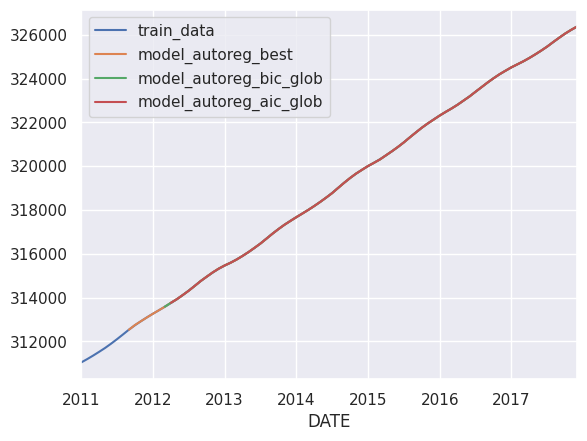

In [95]:
train_data['PopEst'].plot(legend=True, label = 'train_data')
model_autoreg_best.fittedvalues.plot(legend=True, label = 'model_autoreg_best')
model_autoreg_bic_glob.fittedvalues.plot(legend=True, label = 'model_autoreg_bic_glob')
model_autoreg_aic_glob.fittedvalues.plot(legend=True, label = 'model_autoreg_aic_glob')

In [98]:
labels = [f'AR({p_aic}) AIC', f'AR({p_bic}) BIC', f'AR({p})', ]
models = [model_autoreg_aic_glob, model_autoreg_bic_glob, model_autoreg_best ]
for i in range(len(models)):
    error = mean_squared_error(y_true=train_data['PopEst'].loc[models[i].fittedvalues.index[0]:], y_pred=models[i].fittedvalues.loc[models[i].fittedvalues.index[0]:])
    print(f'{labels[i]} RMSE = {np.sqrt(error)}')

AR(13) AIC RMSE = 3.907111217792196
AR(6) BIC RMSE = 4.328414753386743
AR(8) RMSE = 5.2715874987933935


### Retrain on whole data and Predict actual future

In [108]:
model_autoreg_best_whole = AutoReg(df['PopEst'], lags=ar_order).fit()
predictions_to_future = model_autoreg_best_whole.predict(start=end, end=end+12)

In [112]:
df.tail()

,PopEst
DATE,
2018-08-01,327698
2018-09-01,327893
2018-10-01,328077
2018-11-01,328241
2018-12-01,328393
